<a href="https://colab.research.google.com/github/mar-ale-fer/dio-ml-bootcamp/blob/main/maralefer_image_similarity_recommendations_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 20.7 MB/s eta 0:00:00


In [3]:
import kagglehub
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import faiss
import requests
from io import BytesIO
import shutil  # Import shutil for moving directories


In [63]:
import glob
from IPython.display import display
import matplotlib.pyplot as plt

In [35]:

# Download the dataset from Kaggle
path = kagglehub.dataset_download("sunnykusawa/ecommerce-products-image-dataset")
image_dir = os.path.join(path, "ecommerce products")  # Adjust based on dataset structure



In [36]:
print(path)
print(image_dir)

/root/.cache/kagglehub/datasets/sunnykusawa/ecommerce-products-image-dataset/versions/1
/root/.cache/kagglehub/datasets/sunnykusawa/ecommerce-products-image-dataset/versions/1/ecommerce products


In [37]:
print("Files in directory:", os.listdir(path))

Files in directory: []


In [41]:
ecommerce_images = '/content/ecommerce_images'


In [ ]:
!mv "{image_dir} {ecommerce_images}"

In [ ]:
# Load BiT model (ResNet50 pre-trained)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = torch.nn.Identity()  # Remove classification layer to get embeddings
model.eval()



In [6]:

# Image preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension



In [ ]:
# Extract embeddings from dataset
#image_paths = [os.path.join(ecommerce_images, f) for f in os.listdir(ecommerce_images) if f.endswith(".jpg")]
# the images are in subdolders
image_paths = glob.glob(os.path.join(ecommerce_images, "**", "*.jpg"), recursive=True)

#print(image_paths)
embeddings = []
file_names = []

with torch.no_grad():
    for image_path in image_paths:
        #print(f"Processing image: {image_path}")
        img_tensor = preprocess_image(image_path)
        embedding = model(img_tensor).squeeze().numpy()
        embeddings.append(embedding)
        file_names.append(image_path)



In [50]:
# Convert to NumPy array
embeddings = np.array(embeddings, dtype=np.float32)



In [51]:
# Store embeddings in FAISS index
index = faiss.IndexFlatL2(embeddings.shape[1])  # L2 (Euclidean) similarity
index.add(embeddings)


In [57]:

# Function to find similar images
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    if isinstance(image, str):  # If it's a file path
        image = Image.open(image).convert("RGB")

    return transform(image).unsqueeze(0)




In [88]:
# Example query image (replace with actual image URL)

# Jean
#query_image_url = "https://media.istockphoto.com/id/639511940/pt/foto/beautiful-denim-pants.jpg?s=1024x1024&w=is&k=20&c=q5ew2UVWt8kLXDunlPMV3fLxZhK-G1UkU2uP2J9Oct8="  # Replace with actual URL

#TV
#query_image_url = 'https://images.pexels.com/photos/333984/pexels-photo-333984.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2'

#T-Shirt
query_image_url = 'https://http2.mlstatic.com/D_NQ_NP_2X_604271-MLA54966350367_042023-F.webp'

#couch
#query_image_url = 'https://panoverse-cdn.com.br/img.panorama/produto/87861/sofa-4-lugares-living-linho-kaki-viero-moveis-598822-cape.webp'

response = requests.get(query_image_url)
query_image = Image.open(BytesIO(response.content)).convert("RGB")



In [89]:
similar_images = find_similar_images(query_image)
#print("Top 5 similar images:", similar_images)

In [90]:
print("Top 5 similar images:", similar_images)

Top 5 similar images: ['/content/ecommerce_images/tshirt/135.jpg', '/content/ecommerce_images/tshirt/141.jpg', '/content/ecommerce_images/tshirt/134.jpg', '/content/ecommerce_images/tshirt/12.jpg', '/content/ecommerce_images/tshirt/70.jpg']


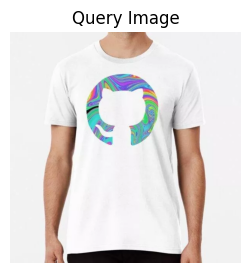

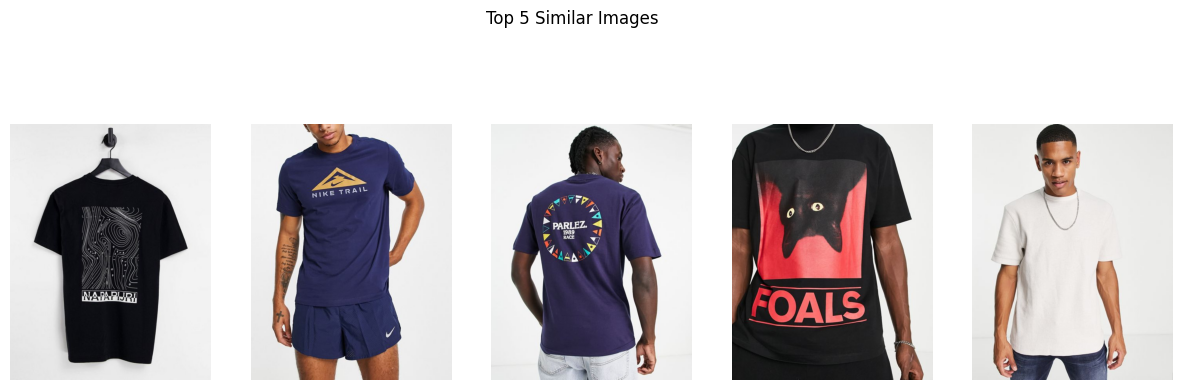

In [91]:

# Display query image
plt.figure(figsize=(3, 3))
plt.imshow(query_image)
plt.axis("off")
plt.title("Query Image")
plt.show()

# Display similar images in a row
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # 1 row, 5 columns
for ax, image_path in zip(axes, similar_images):
    img = Image.open(image_path)
    ax.imshow(img)
    ax.axis("off")

plt.suptitle("Top 5 Similar Images")
plt.show()
